# Feature Engineering, Decision Tree Pruning and Hyperparameter Tuning

### The Data
We will be using the dataset <em>incidents.csv</em>. 

This dataset contains 5000 cases and 13 features, including:

- id
- gender
- age
- hypertension
- heart_disease
- ever_married
- work_type
- Residence_type
- avg_glucose_level
- bmi
- smoking_status
- stroke

## Import Libraries

In [2734]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Get the data

In [2735]:
# https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset
data = pd.read_csv('datasets/healthcare-dataset-stroke-data.csv')

In [2736]:
data.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [2737]:
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [2738]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


# Handling missing data and possible data transformations
- Remove missing values, outliers, and unnecessary rows/ columns
- Check and impute null values
- Check Imbalanced data
- Re-indexing and reformatting our data

## 1. Missing Values

In [2739]:
data.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

<Axes: >

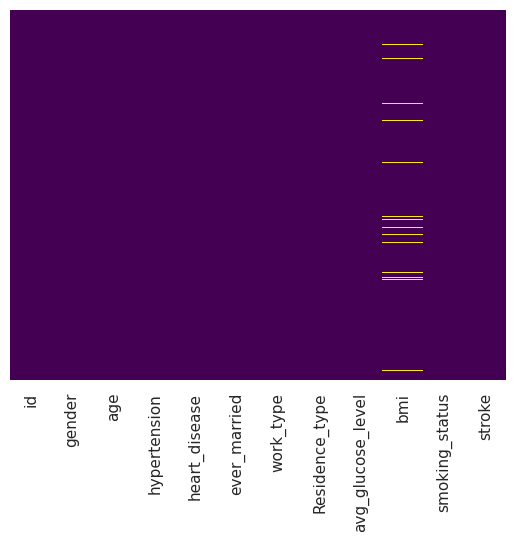

In [2740]:
sns.heatmap(data.isnull(),yticklabels=False,cbar=False,cmap='viridis')

### Drop or fill
Let's verify how the data is presented in the feature <em>affected_roads</em>

In [2741]:
data.drop('id',axis=1,inplace=True)

In [2742]:
data['bmi'].head()

0    36.6
1     NaN
2    32.5
3    34.4
4    24.0
Name: bmi, dtype: float64

In [2743]:
data[data['bmi'].isnull()]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
8,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
13,Male,78.0,0,1,Yes,Private,Urban,219.84,NaN,Unknown,1
19,Male,57.0,0,1,No,Govt_job,Urban,217.08,NaN,Unknown,1
27,Male,58.0,0,0,Yes,Private,Rural,189.84,NaN,Unknown,1
...,...,...,...,...,...,...,...,...,...,...,...
5039,Male,41.0,0,0,No,Private,Rural,70.15,NaN,formerly smoked,0
5048,Male,40.0,0,0,Yes,Private,Urban,191.15,NaN,smokes,0
5093,Female,45.0,1,0,Yes,Govt_job,Rural,95.02,NaN,smokes,0
5099,Male,40.0,0,0,Yes,Private,Rural,83.94,NaN,smokes,0


#### Outliers

<Axes: xlabel='bmi'>

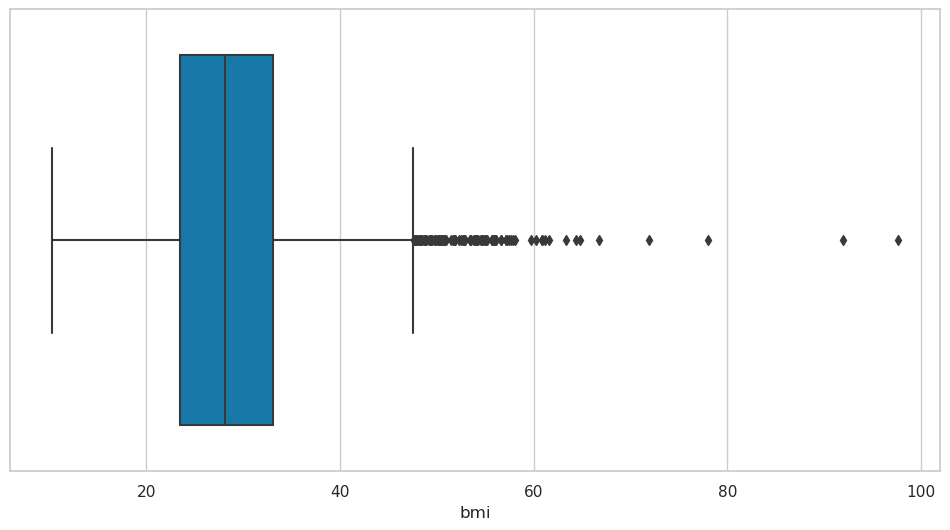

In [2744]:
plt.figure(figsize=(12,6))
sns.boxplot(x=data['bmi'],palette='winter')

In [2745]:
mean = data.loc[data['bmi']<70, 'bmi'].mean()
data.loc[data.bmi > 70, 'bmi'] = np.nan
data.loc[data.bmi < 11, 'bmi'] = np.nan
data.fillna(mean,inplace=True)

<Axes: xlabel='bmi'>

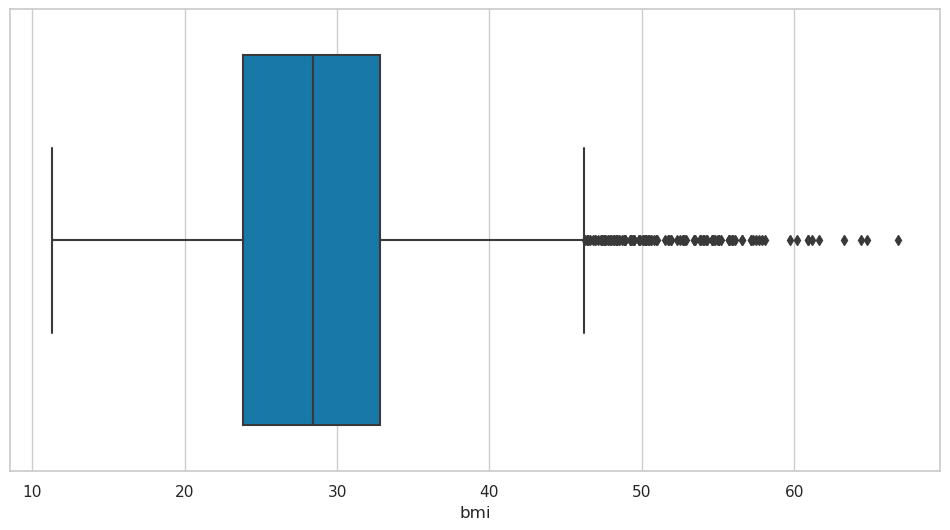

In [2746]:
plt.figure(figsize=(12,6))
sns.boxplot(x=data['bmi'],palette='winter')

Copy of the data to experiment the options

In [2747]:
data_m1 = data.copy()
data_m2 = data.copy()
data_m3 = data.copy()

#### a) Drop

In [2748]:
data_m1.drop(['bmi'],axis=1,inplace=True)
data_m1.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,never smoked,1


#### b) Fill with zero

In [2749]:
data_m2.fillna(0,inplace=True)
data_m2.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.847584,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1


#### c) Fill with the mean

In [2750]:
male_data = data_m3[data_m3['gender'] == 'Male']['bmi'].mean()
#male_data.mean()

female_data = data_m3[data_m3['gender'] == 'Female']['bmi'].mean()

data_m3['bmi'] = data_m3.apply(lambda row: male_data if pd.isna(row['bmi']) and row['gender'] == 'Male' else row['bmi'], axis=1)
data_m3['bmi'] = data_m3.apply(lambda row: female_data if pd.isna(row['bmi']) and row['gender'] == 'Female' else row['bmi'], axis=1)

data_m3.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.847584,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1


We need to choose one of the options to keep going. We will choose to drop the column since it does not bring added value to our goal.

In [2751]:
male_data = data[data['gender'] == 'Male']['bmi'].mean()

female_data = data[data['gender'] == 'Female']['bmi'].mean()

data['bmi'] = data.apply(lambda row: male_data if pd.isna(row['bmi']) and row['gender'] == 'Male' else row['bmi'], axis=1)
data['bmi'] = data.apply(lambda row: female_data if pd.isna(row['bmi']) and row['gender'] == 'Female' else row['bmi'], axis=1)

There are features that are of the type <em>object</em>: <em>city_name</em>, <em>magnitude_of_delay</em>, <em>record_date</em>, <em>luminosity</em>, <em>avg_rain</em> and <em>incidents</em>.

Let's see how many different values each feature has.

In [2752]:
data.nunique()

gender                  3
age                   104
hypertension            2
heart_disease           2
ever_married            2
work_type               5
Residence_type          2
avg_glucose_level    3979
bmi                   414
smoking_status          4
stroke                  2
dtype: int64

## 2. Handling categoric data

Let's see the feature <em>incidents</em>:

In [2753]:
print(data['gender'].value_counts())

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64


In [2754]:
print(data['gender'].value_counts().count())

3


Let's create a barplot of <em>Frequency Distribution of Incidents</em> (style="darkgrid", fontsize=12)

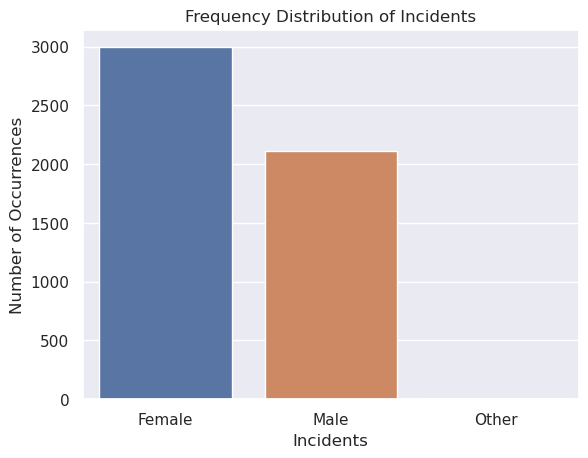

In [2755]:
incidents_count = data['gender'].value_counts()
sns.set(style = "darkgrid")
sns.barplot(x = incidents_count.index, y = incidents_count.values)
plt.title('Frequency Distribution of Incidents')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Incidents', fontsize=12)
plt.show()

Let's create a pie plot of <em>Category Distribution of Incidents</em>

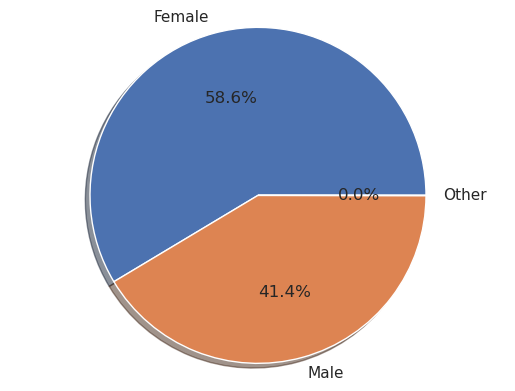

In [2756]:
labels = data['gender'].astype('category').cat.categories.tolist()
counts = data['gender'].value_counts()
sizes = [counts[var_cat] for var_cat in labels]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',shadow=True)
ax1.axis('equal')
plt.show()

We have several options how to deal with qualitative data:

#### a) Replace Values

Again, we are using data copies to experiment all options.

In [2757]:
data_r1=data.copy()
data_r1.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.847584,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1


We need to create a dictionary assigning the string to a numeric value:

'Female': 0, 'Male': 1, 'Other': 2

In [2758]:
replace_map = {'gender': {'Female': 0, 'Male': 1, 'Other': 2}}

We can create a replacement map in other way:

In [2759]:
labels = data_r1['gender'].astype('category').cat.categories.tolist()
replace_map_comp = {'gender' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
print(replace_map_comp)

{'gender': {'Female': 1, 'Male': 2, 'Other': 3}}


In [2760]:
data_r1.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.847584,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1


Now we need to replace with the new values:

In [2761]:
data_r1.replace(replace_map_comp, inplace=True)
data_r1.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,2,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,1,61.0,0,0,Yes,Self-employed,Rural,202.21,28.847584,never smoked,1
2,2,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,1,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,1,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1


Done! Now we can see that the type of values are <em>int64</em>:

In [2762]:
print(data_r1['gender'].dtype)

int64


#### b) Label encoding

In [2763]:
data_r2 = data.copy()
data_r2.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.847584,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1


In [2764]:
print(data_r2.dtypes)

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object


Similar to the previous examples, each string will be assigned a number. Instead of replacing the values under the column <em>incidents</em>, we are going to create a new colum to each created label.

In [2765]:
# data_r2['N/A']=np.where(data_r2['bmi'].str.contains('N/A'),1,0)
# data_r2.head()

To complete the process, it is needed to replicate for each label and then drop the column <em>incidents</em>.

Let's see another way to label encoding. This uses the <em>LabelEncoder</em> from <em>sklearn</em>.

In [2766]:
data_r2_sk1 = data.copy()
data_r22=data.copy()

from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
data_r2_sk1["smoking_status_code"] = lb_make.fit_transform(data_r22["smoking_status"])

data_r2_sk1.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,smoking_status_code
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.847584,never smoked,1,2
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1,2
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1,3
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1,2


It creates a new column, <em>incidents_code</em>, with the labels assigned to feature <em>incidents</em>. The numeric values were assigned randomly, being the crescent order not apllicable to the meaning of the qualifying words.

#### c) One-Hot encoding

This alternative uses <em>LabelBinarizer</em> of <em>sklearn</em> and creates a matrix with bits regarding each label.

In [2767]:
data_r3 = data.copy()

from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
lb_results = lb.fit_transform(data_r3['smoking_status'])
lb_results_df = pd.DataFrame(lb_results, columns=lb.classes_)

lb_results_df.head()

,Unknown,formerly smoked,never smoked,smokes
0,0,1,0,0
1,0,0,1,0
2,0,0,1,0
3,0,0,0,1
4,0,0,1,0


In [2768]:
result_df = pd.concat([data_r3, lb_results_df], axis=1)
result_df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,Unknown,formerly smoked,never smoked,smokes
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1,0,1,0,0
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.847584,never smoked,1,0,0,1,0
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1,0,0,1,0
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1,0,0,0,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1,0,0,1,0


#### d) Binary Encoding
Similar to the previous technique, it creates a matrix of the status of the values, but this time with binary values. See the comparison between techniques below:

|   Level   | "Decimal encoding" | Binary encoding | One-Hot encoding |
| :-------: | :----------------: | :-------------: | :--------------: |
| None      |         0          |       000       |      000001      |
| Low       |         1          |       001       |      000010      |
| Medium    |         2          |       010       |      000100      |
| High      |         3          |       011       |      001000      |
| Very_High |         4          |       100       |      010000      |

For this technique it is needed to have the <em>category_encoders</em> installed:
<code>!pip install category_encoders</code>

In [2769]:
#!pip install category_encoders

data_r4 = data.copy()

import category_encoders as ce

encoder = ce.BinaryEncoder(cols=['smoking_status'])
df_binary = encoder.fit_transform(data_r4)

df_binary.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status_0,smoking_status_1,smoking_status_2,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,0,0,1,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.847584,0,1,0,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,0,1,0,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,0,1,1,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,0,1,0,1


#### e) Backward difference encoding
The values are normalized in the range of -1 to 1.

In [2770]:
data_r5 = data.copy()

encoder = ce.BackwardDifferenceEncoder(cols=['smoking_status'])
df_bd = encoder.fit_transform(data_r5)

df_bd.head()

/home/edini22/miniconda3/envs/DAA/lib/python3.10/site-packages/category_encoders/base_contrast_encoder.py:126: FutureWarning: Intercept column might not be added anymore in future releases (c.f. issue #370)
  warnings.warn("Intercept column might not be added anymore in future releases (c.f. issue #370)",
/home/edini22/miniconda3/envs/DAA/lib/python3.10/site-packages/category_encoders/base_contrast_encoder.py:126: FutureWarning: Intercept column might not be added anymore in future releases (c.f. issue #370)
  warnings.warn("Intercept column might not be added anymore in future releases (c.f. issue #370)",


,intercept,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status_0,smoking_status_1,smoking_status_2,stroke
0,1,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,-0.75,-0.5,-0.25,1
1,1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.847584,0.25,-0.5,-0.25,1
2,1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,0.25,-0.5,-0.25,1
3,1,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,0.25,0.5,-0.25,1
4,1,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,0.25,-0.5,-0.25,1


#### f) Factorize
This technique encodes the object as an enumerated type or categorical variable.

In [2771]:
data_r6 = data.copy()

In [2772]:
data_r6['smoking_status'] = pd.factorize(data_r6['smoking_status'])[0] + 1
data_r6.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,1,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.847584,2,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,2,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,3,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,2,1


We will choose the factorize technique to keep going.

In [2773]:
data['smoking_status'] = pd.factorize(data['smoking_status'])[0] + 1
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,1,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.847584,2,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,2,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,3,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,2,1


Other option would it be to filter the <em>NaN</em> values when reading the CSV file:

<code>data = pd.read_csv('incidents.csv', na_filter=False)</code>

Regarding the features <em>magnitude_delay</em>, <em>luminosity</em> and <em>avg_rain</em>, we will factorize for now.

In [2774]:
data['ever_married'] = pd.factorize(data['ever_married'])[0] + 1
data['work_type'] = pd.factorize(data['work_type'])[0] + 1
data['Residence_type'] = pd.factorize(data['Residence_type'])[0] + 1
# data['stroke'] = pd.factorize(data['stroke'])[0]
data['gender'] = pd.factorize(data['gender'])[0] + 1
data['age'] = data['age'].astype(int)
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67,0,1,1,1,1,228.69,36.600000,1,1
1,2,61,0,0,1,2,2,202.21,28.847584,2,1
2,1,80,0,1,1,1,2,105.92,32.500000,2,1
3,2,49,0,0,1,1,1,171.23,34.400000,3,1
4,2,79,1,0,1,2,2,174.12,24.000000,2,1


# Exploratory Data Analysis

Time to put your data viz skills to the test! Try to recreate the following plots, make sure to import the libraries you'll need!

In [2775]:
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67,0,1,1,1,1,228.69,36.600000,1,1
1,2,61,0,0,1,2,2,202.21,28.847584,2,1
2,1,80,0,1,1,1,2,105.92,32.500000,2,1
3,2,49,0,0,1,1,1,171.23,34.400000,3,1
4,2,79,1,0,1,2,2,174.12,24.000000,2,1


Let's analyze through a heatmap

<Axes: >

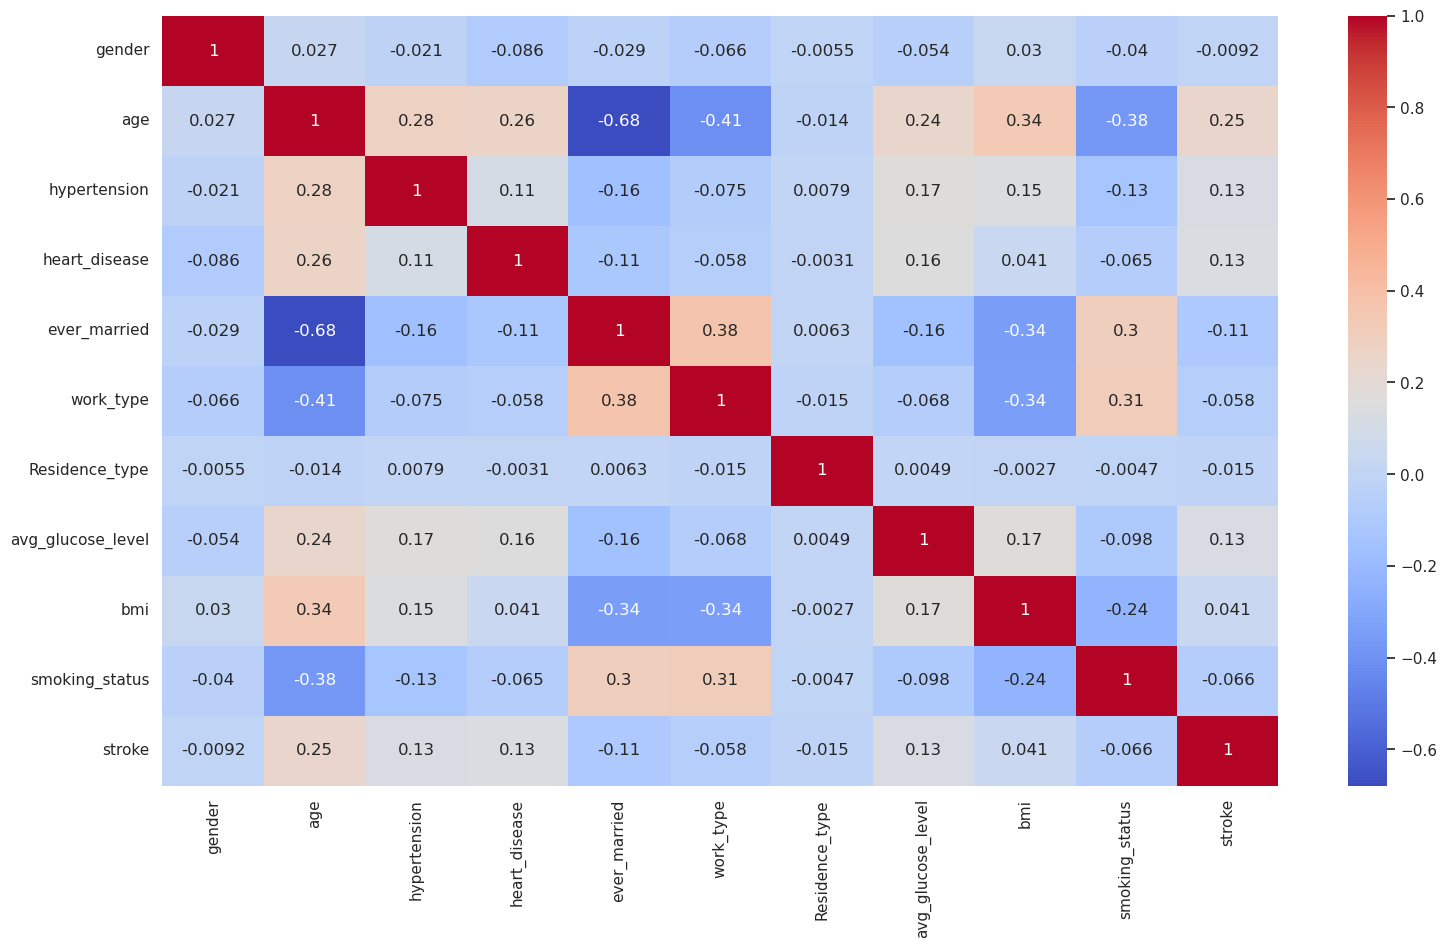

In [2776]:
plt.subplots(figsize=(18,10))
stroke_corr = data.corr(method='pearson')
sns.heatmap(stroke_corr, annot = True, cmap='coolwarm')

We can see that there is a relation between 
- <em>magnitude_of_delay</em> and <em>delay_in_seconds</em>
- <em>magnitude_of_delay</em> and <em>record_date</em>
- <em>avg_humidity</em> and <em>luminosity<em>

Let's see with a pairplot

In [2777]:
# sns.pairplot(data)

It's hard to analyze the relation of all features. Let's create jointplots between the features with notice a relationship.

Jointplot of <em>Magnitude_of_delay vs. Delay_in_seconds</em>

In [2778]:
# sns.set_palette("GnBu_d")
# sns.set_style('whitegrid')
# sns.jointplot(x='magnitude_of_delay',y='delay_in_seconds',data=data)

Jointplot <em>Luminosity vs. Avg_temperature</em>

In [2779]:
# sns.jointplot(x='luminosity',y='avg_temperature',data=data)

Jointplot <em>Avg_humidity vs. Delay_in_seconds</em>

In [2780]:
# sns.jointplot(x = 'avg_humidity', y = 'delay_in_seconds', data = data)

Jointplot <em>Avg_temperature vs. Avg_humidity</em>

In [2781]:
# sns.jointplot(x = 'avg_temperature', y = 'avg_humidity', data = data)

It seems there are a relation between <em>Avg_temperature</em> and <em>Avg_humidity</em>. Let´s create a lmplot <em>Avg_temperature vs. Avg_humidity</em>

In [2782]:
# sns.lmplot(x = 'avg_temperature', y = 'avg_humidity', data = data)

In [2783]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   int64  
 1   age                5110 non-null   int64  
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   int64  
 5   work_type          5110 non-null   int64  
 6   Residence_type     5110 non-null   int64  
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                5110 non-null   float64
 9   smoking_status     5110 non-null   int64  
 10  stroke             5110 non-null   int64  
dtypes: float64(2), int64(9)
memory usage: 439.3 KB


In [2784]:
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67,0,1,1,1,1,228.69,36.600000,1,1
1,2,61,0,0,1,2,2,202.21,28.847584,2,1
2,1,80,0,1,1,1,2,105.92,32.500000,2,1
3,2,49,0,0,1,1,1,171.23,34.400000,3,1
4,2,79,1,0,1,2,2,174.12,24.000000,2,1


In [2785]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   int64  
 1   age                5110 non-null   int64  
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   int64  
 5   work_type          5110 non-null   int64  
 6   Residence_type     5110 non-null   int64  
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                5110 non-null   float64
 9   smoking_status     5110 non-null   int64  
 10  stroke             5110 non-null   int64  
dtypes: float64(2), int64(9)
memory usage: 439.3 KB


## Exploratory Data Analysis

### Train Test Split

In [2786]:
from sklearn.model_selection import train_test_split

In [2787]:
train_data, test_data = train_test_split(data, test_size=0.3, random_state=2021)

In [2788]:
data_feat = train_data.drop(['stroke'], axis = 1)

In [2789]:
data_target = train_data.stroke

In [2790]:
x_train = data_feat
y_train= np.ravel(data_target) 

In [2791]:
test_feat = test_data.drop(['stroke'], axis = 1)

In [2792]:
test_target = test_data.stroke

In [2793]:
test_data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
2085,1,70,0,0,1,1,2,72.56,30.4,1,0
2813,1,43,0,0,1,1,1,91.13,33.9,2,0
451,1,13,0,0,2,4,1,122.31,15.3,2,0
3133,2,16,0,0,2,1,1,87.16,28.2,2,0
5005,2,21,0,0,2,1,2,71.34,24.0,2,0


In [2794]:

x_test = test_feat
y_test = np.ravel(test_target)

<Axes: xlabel='Stroke', ylabel='count'>

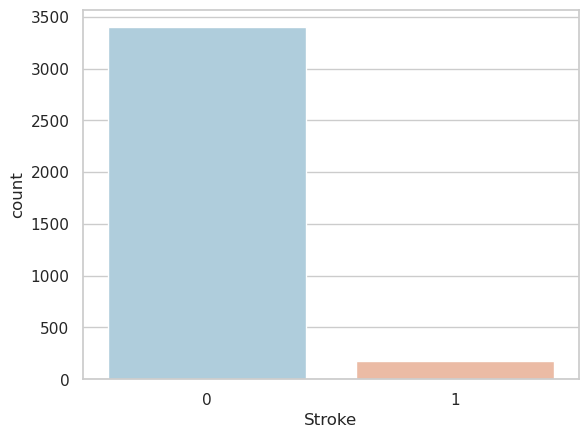

In [2795]:
sns.set_style('whitegrid')
sns.countplot(x='Stroke',data=pd.DataFrame(y_train, columns=['Stroke']),palette='RdBu_r')

<Axes: xlabel='Stroke', ylabel='count'>

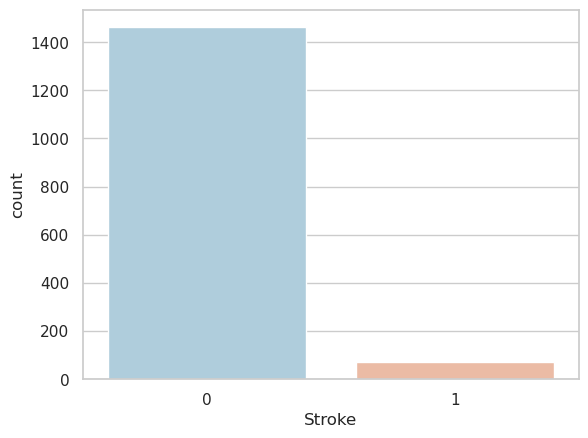

In [2796]:
sns.set_style('whitegrid')
sns.countplot(x='Stroke',data=pd.DataFrame(y_test, columns=['Stroke']),palette='RdBu_r')

In [2797]:
!pip install imblearn 

In [2798]:
from imblearn.over_sampling import SMOTE


### Oversampling the data

In [2799]:
count0, count1 = train_data.stroke.value_counts()
print("negativo -> ",count0,"positivo -> ",count1)

x = data.drop(['stroke'], axis = 1)
y = np.ravel(data.stroke)


sm = SMOTE(sampling_strategy='auto',random_state=1000)
x_train_s, y_train_s = sm.fit_resample(x, y)

train_data_OS = pd.DataFrame(x_train_s,columns=x_train_s.columns)
train_data_OS['stroke'] = y_train_s

train_data_OS.head()
mask = train_data_OS.isin(test_data.to_dict(orient='list')).all(axis=1)

# Filtrar as linhas que não estão em df2
train_data_OS = train_data_OS[~mask]

train_data_OS.head()


negativo ->  3399 positivo ->  178


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
2,1,80,0,1,1,1,2,105.92,32.5,2,1
3,2,49,0,0,1,1,1,171.23,34.4,3,1
4,2,79,1,0,1,2,2,174.12,24.0,2,1
5,1,81,0,0,1,1,1,186.21,29.0,1,1
6,1,74,1,1,1,1,2,70.09,27.4,2,1


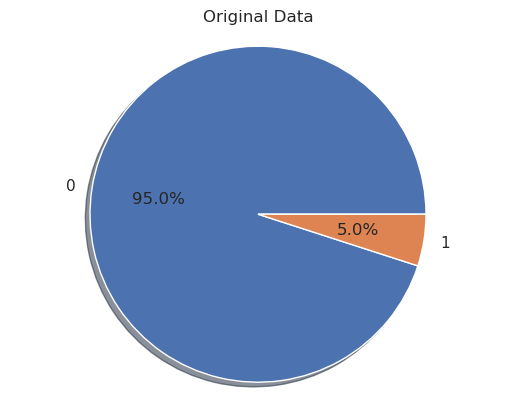

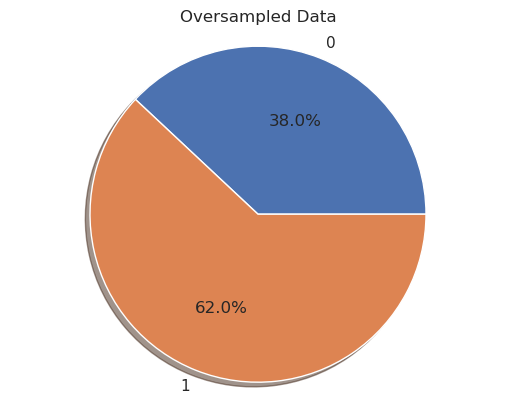

In [2800]:
# # Primeiro Gráfico
# plt.subplot(1, 2, 1)
labels = train_data['stroke'].astype('category').cat.categories.tolist()
counts = train_data['stroke'].value_counts()
sizes = [counts[var_cat] for var_cat in labels]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True)
ax1.axis('equal')
plt.title('Original Data')
plt.show()
# Segundo Gráfico
# plt.subplot(1, 2, 2)
labels = train_data_OS['stroke'].astype('category').cat.categories.tolist()
counts = train_data_OS['stroke'].value_counts()
sizes = [counts[var_cat] for var_cat in labels]
fig2, ax2 = plt.subplots()
ax2.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True)
ax2.axis('equal')
plt.title('Oversampled Data')


# Exibe os gráficos
plt.show()

In [2801]:
data_OS_feat = train_data_OS.drop(['stroke'], axis = 1)

In [2802]:
data_OS_target = train_data_OS.stroke

In [2803]:


x_train_OS = data_OS_feat
y_train_OS = np.ravel(data_OS_target)


In [2804]:
# y_train_OS.value_counts()

In [2805]:
rois = np.array(y_train_OS)
df_rois = pd.DataFrame(rois, columns=['Stroke'])

In [2806]:
print(df_rois['Stroke'].value_counts())


Stroke
1    4770
0    2926
Name: count, dtype: int64


<Axes: xlabel='Stroke', ylabel='count'>

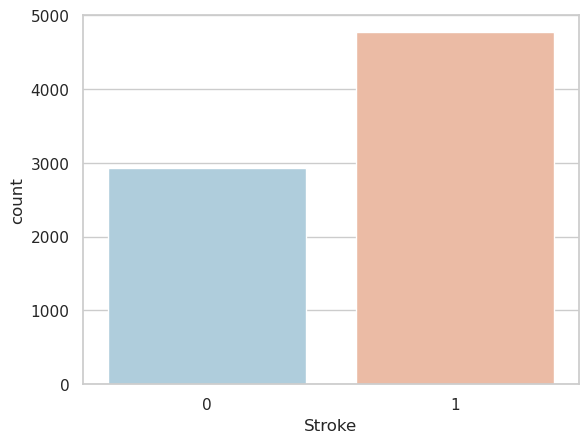

In [2807]:
# Criando o gráfico
sns.set_style('whitegrid')
sns.countplot(x='Stroke', data=df_rois, palette='RdBu_r')

### Set up the dataframe

## Train the Support Vector Classifier

### 10-Fold Cross Validation

In [2808]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

In [2809]:
cross_valid_model = SVC(random_state=2021)
scores = cross_val_score(cross_valid_model, data_feat, np.ravel(data_target), cv=10)
scores

array([0.94972067, 0.94972067, 0.94972067, 0.94972067, 0.94972067,
       0.94972067, 0.94972067, 0.95238095, 0.95238095, 0.94957983])

In [2810]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.95 accuracy with a standard deviation of 0.00


And now without Cross Validation:

In [2811]:
from sklearn.svm import SVC

In [2812]:
model = SVC(random_state=2021)

In [2813]:
model.fit(x_train,y_train)

SVC(random_state=2021)

### Predictions and evaluations

Let's predict using the trained model:

In [2814]:
predictions = model.predict(x_test)

In [2815]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score

In [2816]:
print("%0.2f accuracy" % (accuracy_score(y_test,predictions)))

0.95 accuracy


In [2817]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1462
           1       0.00      0.00      0.00        71

    accuracy                           0.95      1533
   macro avg       0.48      0.50      0.49      1533
weighted avg       0.91      0.95      0.93      1533



/home/edini22/miniconda3/envs/DAA/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/edini22/miniconda3/envs/DAA/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/edini22/miniconda3/envs/DAA/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

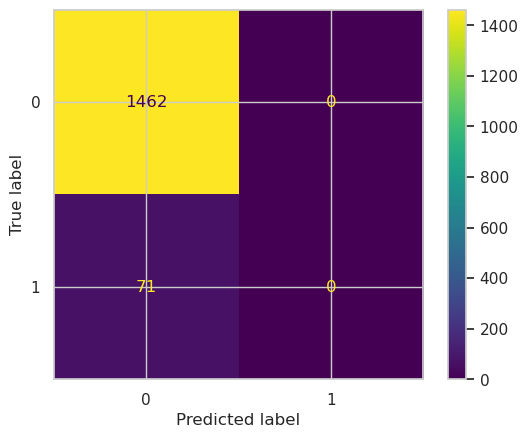

In [2818]:
ConfusionMatrixDisplay.from_predictions(y_test, predictions)
plt.show()

In [2819]:
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

In [2820]:
modelDecisionTree = DecisionTreeClassifier()
scores = cross_val_score(modelDecisionTree, data_feat, data_target, cv=10)
print("Result for Decision Tree: %0.4f accuracy with standard deviation of %0.2f" % (scores.mean(), scores.std()))
#Train the model using the training sets y_pred=clf.predict(X_test)

Result for Decision Tree: 0.9036 accuracy with standard deviation of 0.01


              precision    recall  f1-score   support

           0       0.96      0.95      0.96      1462
           1       0.14      0.15      0.15        71

    accuracy                           0.92      1533
   macro avg       0.55      0.55      0.55      1533
weighted avg       0.92      0.92      0.92      1533



<function matplotlib.pyplot.show(close=None, block=None)>

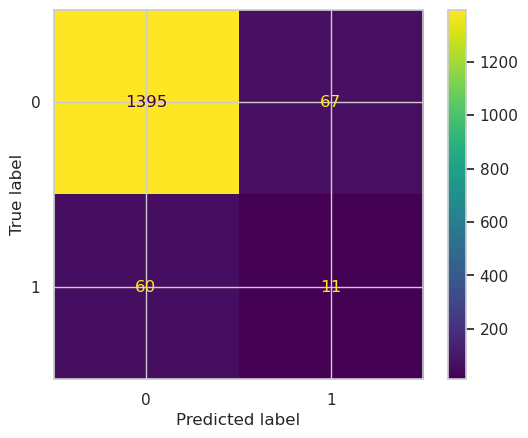

In [2821]:
modelDecisionTree.fit(x_train,y_train)
predictions = modelDecisionTree.predict(x_test)
print(classification_report(y_test,predictions))
ConfusionMatrixDisplay.from_predictions(y_test, predictions)
plt.show

              precision    recall  f1-score   support

           0       0.98      0.86      0.92      1462
           1       0.18      0.61      0.27        71

    accuracy                           0.85      1533
   macro avg       0.58      0.73      0.60      1533
weighted avg       0.94      0.85      0.89      1533

85.13 accuracy


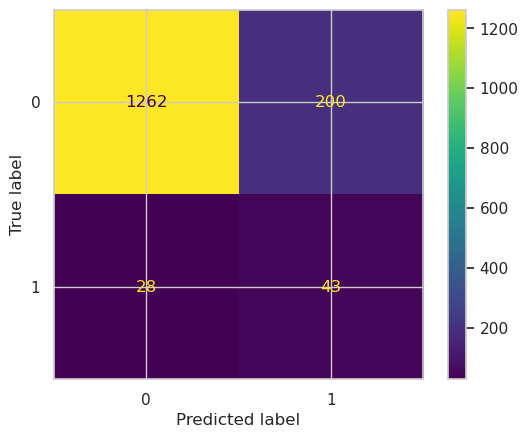

In [2822]:
modelDecisionTree.fit(x_train_OS,y_train_OS)
predictions = modelDecisionTree.predict(x_test)
print(classification_report(y_test,predictions))
ConfusionMatrixDisplay.from_predictions(y_test, predictions)
plt.show
print("%0.2f accuracy" % ((accuracy_score(y_test,predictions))*100))

In [2823]:
test_data.stroke.value_counts()

stroke
0    1462
1      71
Name: count, dtype: int64